(hgf_exercises_1)=
# Zurich CPC I: Introduction to the Generalised Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/Exercise_1_Introduction_to_the_generalised_hierarchical_gaussian_filter.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyhgf import load_data
from pyhgf.model import Network

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


```{note}
This tutorial is the first part of an introductory tutorial to the generalised Hierarchical Gaussian Filter delivered to the [Zurich Computational Psychiatry Course 2024](https://www.translationalneuromodeling.org/cpcourse/). We estimate both tutorials to take about 3-4 hours to complete. 
```

In the first part of the workshop, we will introduce the theoretical foundations of the generalised Hierarchical Gaussian Filter (gHGF). We have seen in the previous presentations that the gHGF can be seen as an instance of dynamic hierarchical networks, a very flexible and versatile family of networks. We want now to see how such networks can be turned into a generative model of nested stochastic processes that describe hidden states of the world.

We will start by reviewing the mathematical description of such operations and how to implement them in standard Python/Numpy. Then, we will start using PyHGF and see how it can help us invert this generative model, so we can update beliefs when presented with observations (what we call here running the model forward). 

We will then apply this to real-world data (weather dataset) by creating an agent that *uses* this model to filter sensory information and update internal beliefs about hidden states of the world.

## The generative model
### Gaussian Random Walks

The gHGF is built as a generalisation and nodalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW), which means that each node in the network encodes a GRW and can influence or be influenced by another child/parent node. A GRW is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) that generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ as its mean such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the fixed variance of the distribution. You can find more details on this as well as some code to get started with the simulations in the first tutorial on the [PyHGF documentation](https://computationalpsychiatry.github.io/pyhgf/notebooks/0.1-Theory.html#).

```{exercise}
:label: exercise1.1

Using the equation above, write a Python code that implements a Gaussian random walk using the following parameters: $\sigma^2 = 1$ and $x_1^{(0)} = 0$.
```

### Probabilistic coupling between nodes

We have simulated above a simple GRW. At each time point, this process is fully described by the implied Normal distribution, which is parametrised by the mean and the variance. The gHGF hierarchically generalize this process by making the parameters of a stochastic process depend on another node at a different level, and thus another GRW {cite:p}`weber:2023`. But because a Gaussian distribution is defined by two parameters (mean and variance), we can distinguish two ways for a node to influence another node: **value coupling** (targetting the value $\mu$ of the child node) or **volatility coupling** (targetting the volatility $\sigma^2$ of the child node).

#### Value coupling

Let's consider for example a network constituted of two nodes $x_1$ and $x_2$, as it is found in the continuous HGF {cite:p}`2014:mathys`. The node $x_1$ is performing a GRW as previously described. We can add a dependency on the mean of the distribution (**value coupling**) by assuming that $x_1$ inherits the difference step from $x_2$, instead of using only its own previous value. Mathematically, this would write:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \sigma_2^2) \\
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + x_2^{(k)}, \, \sigma_1^2) \\
$$

```{hint}
This generative process reads top-down: the node higher in the hierarchy ($x_2$) generates new values and passes them to the child nodes. We can also control how much the node $x_1$ is influenced by its previous (see examples [here](https://computationalpsychiatry.github.io/pyhgf/notebooks/0.1-Theory.html#value-coupling)). To keep things simple in this exercise, we will assume that $x_1$ is fully influenced by its previous value, as noted in the equation, therefore $x_2$ can be seen as a *drift parent*.
```

Let's define a time series `x_2` that represent the evolution of the states of the parent node:

In [3]:
x_2 = np.tile(np.repeat([0, 1, 0, -2], 125) * 0.5, 2)

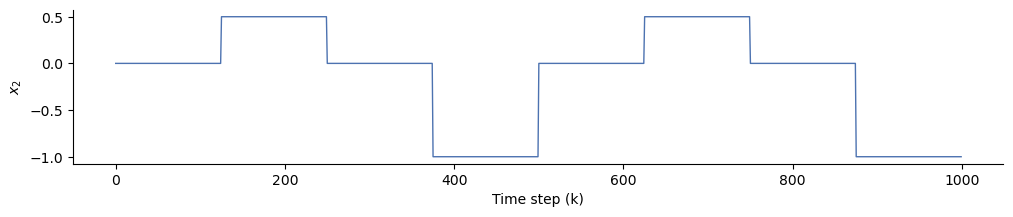

In [4]:
plt.figure(figsize=(12, 2))
plt.plot(x_2, linewidth=1, color="#4c72b0")
plt.xlabel("Time step (k)")
plt.ylabel("$x_{2}$")
sns.despine()

```{exercise}
:label: exercise1.2

Write a Python code that generates values for $x_1$ using the value coupling equation above with $\mu_1^{0} = 0.0$ and $\sigma_1 = 1.5$.
```

#### Volatility coupling

We can of course arrange things differently, making this time $x_2$ having an influence on the *variance* of $x_1$ instead. This is what we call **volatility coupling** and this will be of particular interest for computational psychiatry as this will let us create agents that dynamically learn uncertainty about their beliefs. This means that for state $x_1$, the mean of the Gaussian random walk on time point $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(x_2^{(k)} + \omega_1)
$$


```{hint}
- Here the volatility is not simply inherited from the higher node, it is mixed with another quantity ($\omega_1$). This is because we don't want the parent node to explain all the variance alone, the child node ($x_1$) also has a parameter for its own variance and expects some variability by itself. The parent node can weigh on this by adding or removing variance in the final quantity. $\omega$ is sometimes refered to as the *tonic* part of the variance, or the *evolution rate*, while $x_2$ is the *phasic* part of the variance.
- We use the exponential to ensure that the variance will always be positive.
```

Let's create a new time series for the volatility parent $x_2$:

In [5]:
x_2 = np.tile(np.repeat([0, 1], 1000), 5) * 6

```{exercise}
:label: exercise1.3

- Using the equation above and your previous implementation, write a Python code that generates values for $x_1$ with $\omega_1 = -6.0$, $\mu_1^{(0)} = 0.0$,

- What happens when we increase the values of $\omega_1$?

- What happens to $x_1$ when the variable $x_2$ increases its value?
```

## Model inversion: the generalized Hierarchical Gaussian Filter

Building on these principles, we can create networks of arbitrary size and shape made of probabilistic nodes (nodes that represent the evolution of a Gaussian Random Walk) that can be connected with each other through **value** or **volatility** coupling. We have covered these points in the previous exercise using a simplified network made of two nodes.

[PyHGF](https://computationalpsychiatry.github.io/pyhgf/index.html) adds most of its values in that it allows the creation and manipulation of large and complex networks easily, and it automates the transmission of values between nodes. You can refer to [the second part of the tutorial documentation](https://computationalpsychiatry.github.io/pyhgf/notebooks/0.2-Creating_networks.html) which covers the manipulation of networks for more details. 

But this is not the only thing it does. So far we have simulated observations from the generative model, going for the leaves to the root of the network. This describes how we expect the environment to behave, but not how an agent would learn from it. To do so we need to invert this model: we want to provide the observations, and let the network update the nodes accordingly, so the beliefs always reflect the current state of the environment. This process requires propagating precision prediction errors from the root to the leaves of the network, and this is where most of PyHGF's dark magic is most useful.

```{figure} https://raw.githubusercontent.com/ComputationalPsychiatry/pyhgf/master/docs/source/images/graph_network.svg
---
name: networks
---

PyHGF is designed to automate the propagation of prediction (top-down) and prediction errors (bottom-up) in dynamic probabilistic networks. Predictions are triggered from the leaves to the roots of the networks prior to observation. Prediction errors and posterior updates a triggered after observation, from the roots to the leaves.

```

In the following example, we illustrate how we can create a network with a more complex structure (i.e. a two-level continuous Hierarchical Gaussian Filter) and how this model can be inverted to update beliefs when presented with new observations.

In [6]:
# load an example time series for continuous inputs
timeseries = load_data("continuous")

In [7]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(kind="continuous-state", value_children=0)
    .add_nodes(kind="continuous-state", volatility_children=1)
)

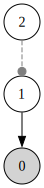

In [8]:
# plot the implied probabilistic network
two_levels_continuous_hgf.plot_network()

In [9]:
# add new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeseries)

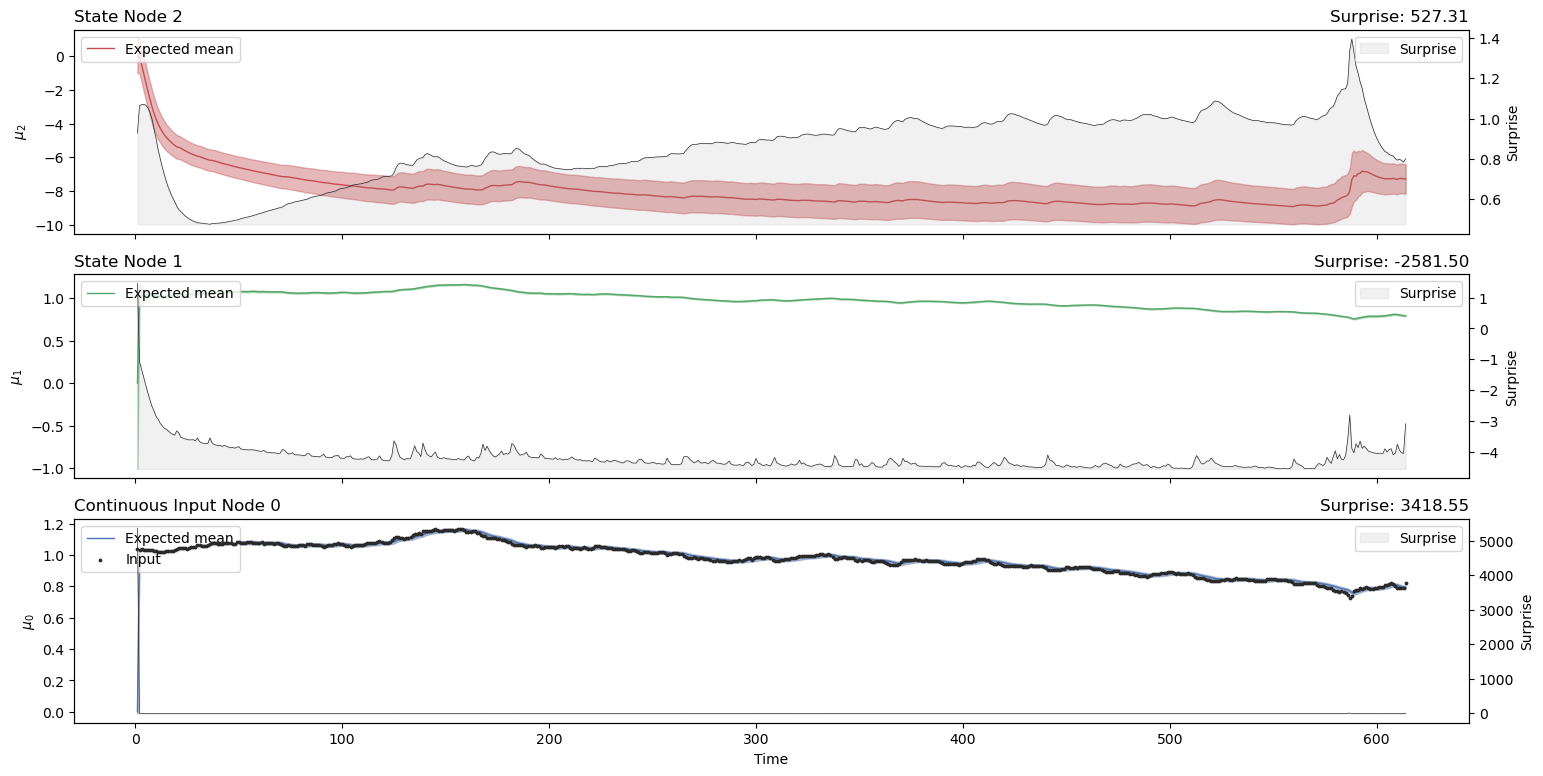

In [10]:
# plot the trajectories of the model beliefs
two_levels_continuous_hgf.plot_trajectories();

```{exercise}
:label: exercise1.4

Each state node comes with parameters `mean`, `precision` and `tonic_volatility` that can be provided when creating the network. Using the function above, try to change these values. How does this influence the belief trajectories? 

```

## Practice: Filtering the worlds weather

In the previous section, we introduced the computational concept behind the generalised Hierarchical Gaussian Filter. For the time left before the break, you are going to apply this knowledge to a more practical context: filtering the world's weather. We will use data from {cite:p}`pfenninger:2016, staffell:2016` that is made available [here](https://renewables.ninja/). This database contains hourly recordings of various weather parameters that have been tracked over one year at different positions in the world. The data from Aarhus can be loaded using the following function call:

In [11]:
aarhus_weather_df = pd.read_csv(
    "https://raw.githubusercontent.com/ComputationalPsychiatry/hgf-data/main/datasets/weather.csv"
)
aarhus_weather_df.head()

,time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
0,2019-01-01 00:00,7.387,0.124,0.0,0.0,1.249,0.0,0.0,0.931
1,2019-01-01 01:00,7.472,0.200,0.0,0.0,1.247,0.0,0.0,0.865
2,2019-01-01 02:00,7.635,0.196,0.0,0.0,1.244,0.0,0.0,0.701
3,2019-01-01 03:00,7.224,0.061,0.0,0.0,1.245,0.0,0.0,0.387
4,2019-01-01 04:00,6.147,0.018,0.0,0.0,1.250,0.0,0.0,0.128


The data frame contains the following parameters, recorded every hour over the year of 2019:

| parameter | description |
| --- | --- |
| t2m | The 2-meter above ground level air temperature |
| prectotland | The rain precipitation rate (mm/hour) |
| precsnoland | Snow precipitation rate (mm/hour) |
| snomas | Total snow storage land (kg/m2) |
| rhoa | Air density at surface (kg/m3) |
| swgdn | Surface incoming shortwave flux (W/m2) (considering cloud cover) (The value at the surface is approximately 1000 W/m2 on a clear day at solar noon in the summer months) |
| swtdn | Toa (top of atmosphere) incoming shortwave flux (W/m2) |
| cldtot | Total cloud area fraction. An average over grid cells and summed over all height above ground ([0,1] scale where 0 is no cloud and 1 is very cloudy) |

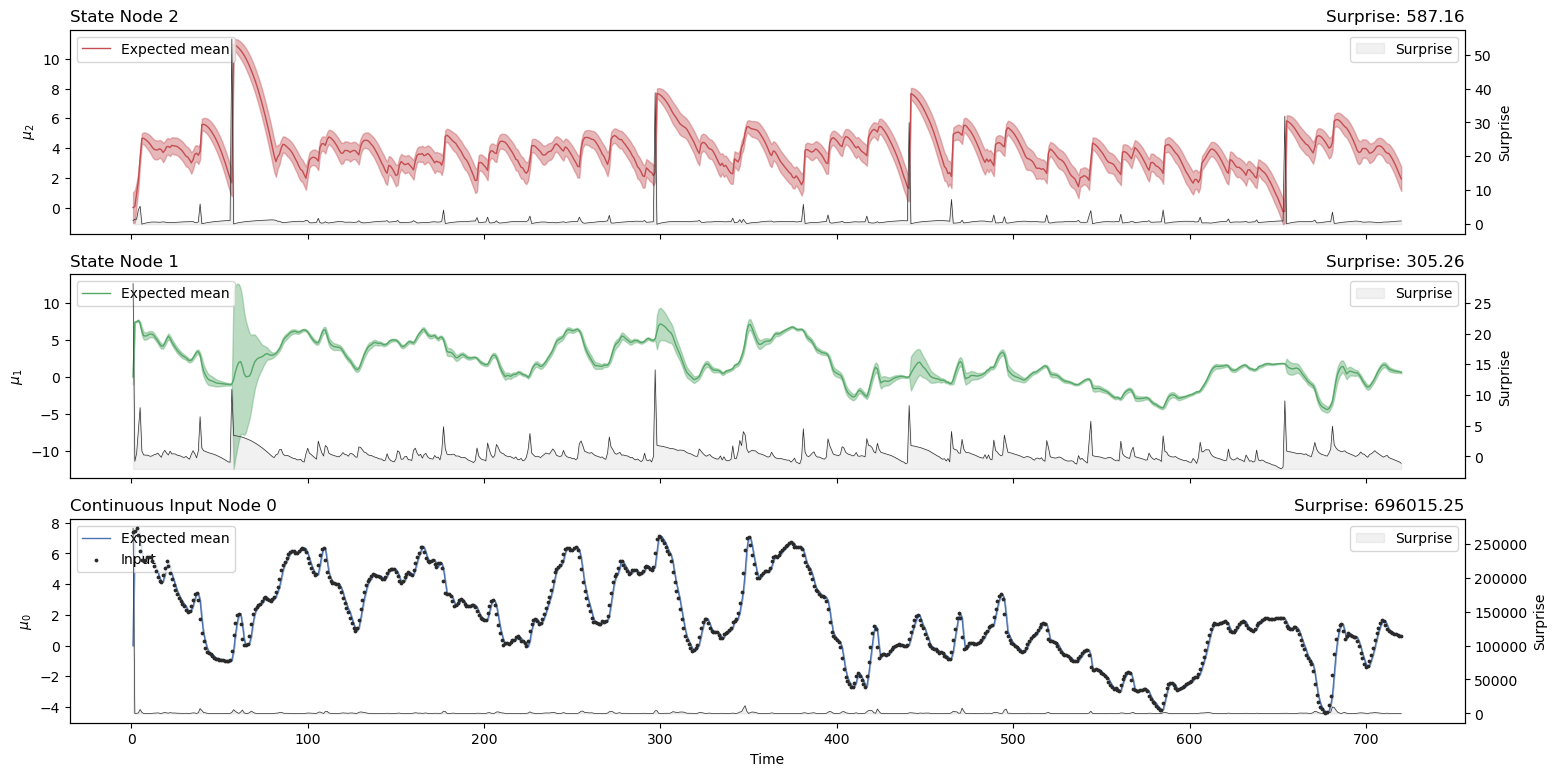

In [12]:
# Load time series example data
timeserie = aarhus_weather_df["t2m"][: 24 * 30].to_numpy()

# This is where we define all the model parameters - You can control the value of
# different variables at different levels using the corresponding dictionary.

hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-6.0)
    .add_nodes(kind="continuous-state", volatility_children=1, tonic_volatility=-3.0)
)

# add new observations
hgf.input_data(input_data=timeserie)

# visualization of the belief trajectories
hgf.plot_trajectories();

In [13]:
from pyhgf.response import first_level_gaussian_surprise

hgf.surprise(response_function=first_level_gaussian_surprise).sum()

Array(308.5377, dtype=float32)

```{exercise}
:label: exercise1.5

What quantity are we measuring in the code cell above? What does this represent?
```

```{exercise}
:label: exercise1.6

- Select a city and download a recording OR use the data frame loaded above.
- Fit a network using one of the variables and estimate the total Gaussian surprise.
- Can you try to come up with a better model (one that would minimize the total Gaussian surprise)? You can try to change the initial mean and precision of the tonic volatility or add a layer to the network.
```

# Solutions

````{solution} exercise1.1
:label: solution-exercise1.1

We can simulate a simple Gaussian Random Walk in Python either using a for loop and a list:

```{code-block} python

np.random.seed(123)
grw_1, mean = [], 0.0
for _ in range(200):
    mean = np.random.normal(loc=mean, scale=1)
    grw_1.append(mean)

```

Or using Numpy's built-in `cumsum` function.

```{code-block} python

np.random.seed(123)
grw_2 = np.cumsum(np.random.normal(loc=0, scale=1, size=200))

```

Both methods will generate the same result. The Numpy version is more concise, but can be more difficult to debug when we have nested GRW.

```{code-block} python

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 3))
plt.plot(grw_1, "o-", alpha=.4, label="Loop");
plt.plot(grw_2, "o-", alpha=.4, label="Cumsum");
plt.xlabel("Time step (k)");
plt.ylabel("$x_{1}$");
plt.legend()
sns.despine()

```

````

````{solution} exercise1.2
:label: solution-exercise1.2

We can simulate values from $x_1$ using a for loop:

```{code-block} python

x_1, mu_1, sigma_1 = [], 0.0, 1.5
for x in x_2:
    mu_1 = np.random.normal(mu_1 + x, sigma_1)
    x_1.append(mu_1)

plt.plot(x_1)

```

````

````{solution} exercise1.3
:label: solution-exercise1.3

We can simulate values from $x_1$ using a for loop:

```{code-block} python

x_1, mu_1, sigma_1 = [], 0.0, 1.5
for x in x_2:
    mu_1 = np.random.normal(mu_1 + x, sigma_1)
    x_1.append(mu_1)

plt.plot(x_1)

```

````

````{solution} exercise1.4
:label: solution-exercise1.4

The code below will change mean, precision and tonic volatility at the first level. Here we use Python's OOP features to express model creation, input data and plotting by chaining method call.

```{code-block} python

(
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(kind="continuous-state", value_children=0, mean=1.0, precision=1e2, tonic_volatility=-2.0)
    .add_nodes(kind="continuous-state", volatility_children=1)
    .input_data(input_data=timeseries)
    .plot_trajectories()
);

```

````

````{solution} exercise1.5
:label: solution-exercise1.5

This method return the Gaussian surprise at each time point, which are then summed. The sum of the Gaussian surprise reflect the performances of the model at predicting the next value, larger values pointing to a model more surprise by its inputs, therefore poor performances. The surprise is define as $s = -log(p)$, this is thus the negative of the log probability function. Log probability functions are commonly used by sampling algorithm, it is thus straigthforwars to sample a model parameters when this function is available. There are an infinity of response possible functions - just like there is an infinity of possible networks - for more details on how to use tem, you can refer to the [tutorial on custom response models](https://computationalpsychiatry.github.io/pyhgf/notebooks/2-Using_custom_response_functions.html).

````

# System configuration

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Sep 27 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.4
jax   : 0.4.31
jaxlib: 0.4.31

pandas    : 2.2.2
IPython   : 8.23.0
numpy     : 1.26.0
matplotlib: 3.8.4
seaborn   : 0.13.2
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]

Watermark: 2.4.3

